In [209]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments
from functions.inequality import gini
from distribution_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from functions.evolutionaryalgo import *
from SALib.sample import latin

In [2]:
style.use('ggplot')

# Wealth inequality and asset price volatility

This notebook contains the following steps:

1. Estimation of uncertain parameters
2. Short-run model dynamics
3. Steady state model dynamics
4. Experiment 1 
5. Experiment 2

## 1 Estimation of uncertain parameters

### 1.1 Collect data

In [254]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
price_div = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

In [255]:
emp_moments = np.array([
    p_returns.skew(),
    autocorrelation_returns(p_returns, 25),
    autocorrelation_abs_returns(p_returns, 25),
    kurtosis(p_returns),
    pd_returns.skew(),
    autocorrelation_returns(pd_returns, 25),
    autocorrelation_abs_returns(pd_returns, 25),
    kurtosis(pd_returns),
    ])

In [256]:
emp_moments

array([-0.71126058,  0.00952201,  0.05360488,  2.67789658, -0.65200096,
        0.0075641 ,  0.06170896,  2.64338843])

### 1.2 Bootstrap data
For this, I use the block bootstrap procedure

In [280]:
block_size = 25 # 600 / 25 = 24 blocks

To ensure continuity in the bootstrapped series, I block bootstrap the returns of the price to dividends ratio(not the ratio itself). Then, I multiply these returns with the starting values of the price to dividends ratio. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [281]:
pd_data_blocks = []
p_data_blocks = []
for x in range(0, len(pd_returns[:-3]), block_size):
    pd_data_blocks.append(pd_returns[x:x + block_size])
    p_data_blocks.append(p_returns[x:x + block_size])

In [294]:
BOOTSTRAPS = 100

In [295]:
bootstrapped_pd_returns = []
bootstrapped_p_returns = []
for i in range(BOOTSTRAPS):
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)
    
    sim_data_pd = [random.choice(pd_data_blocks) for _ in pd_data_blocks]
    sim_data2_pd = [j for i in sim_data_pd for j in i]
    bootstrapped_pd_returns.append(sim_data2_pd)

In [296]:
rets_skews = []
rets_autocor = []
rets_autocor_abs = []
rets_kurt = []

for rets in bootstrapped_p_returns:
    rets_skews.append(pd.Series(rets).skew())
    rets_autocor.append(autocorrelation_returns(rets, 25))
    rets_autocor_abs.append(autocorrelation_abs_returns(rets, 25))
    rets_kurt.append(kurtosis(pd.Series(rets)))

In [297]:
pd_rets_skews = []
pd_rets_autocor = []
pd_rets_autocor_abs = []
pd_rets_kurt = []

for rets in bootstrapped_pd_returns:
    pd_rets_skews.append(pd.Series(rets).skew())
    pd_rets_autocor.append(autocorrelation_returns(rets, 25))
    pd_rets_autocor_abs.append(autocorrelation_abs_returns(rets, 25))
    pd_rets_kurt.append(kurtosis(pd.Series(rets)))

In [298]:
all_bootstrapped_moments = [rets_skews,
                            rets_autocor,
                            rets_autocor_abs,
                            rets_kurt,
                            pd_rets_skews,
                            pd_rets_autocor,
                            pd_rets_autocor_abs,
                            pd_rets_kurt
                           ]

In [299]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_pd_returns))]

### 1.3 Estimate weighting matrix:

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [300]:
# Get the t-critical value**
def confidence_intervalz(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [301]:
W_hat = 1.0 / len(bootstrapped_pd_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)

In [302]:
# save weighting matrix
np.save('distr_weighting_matrix', W)

### 1.4 Establish confidence intervals 

In [303]:
confidence_intervals = [confidence_intervalz(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [304]:
confidence_intervals

[(-1.1984742525658048, -0.22404690373078162),
 (-0.0203768474086226, 0.03942086742494884),
 (0.005292741486170503, 0.10191701329624353),
 (0.6020342862641126, 4.753758880967614),
 (-1.0558345831254368, -0.2481673288461238),
 (-0.02315415630148292, 0.03828236545593764),
 (0.017301172194261215, 0.10611674350606312),
 (0.6520154210733828, 4.634761439568542)]

Then, I apply the cost function to the bootstrapped series to get a distribution of J-values

In [305]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

And, I calculate the MCR's for the bootstrapped moments

In [306]:
scores = [0 for x in moments_b[0]]
for bootstr in range(len(moments_b)):
    for idx, moment in enumerate(moments_b[bootstr]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1
MCR_bootstrapped_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_b))

In [307]:
MCR_bootstrapped_moments

array([0.99, 0.97, 0.97, 0.99, 1.  , 0.98, 0.92, 0.98])

### 1.5 Sample the parameter space with Latin Hypercube Sampling 

In [308]:
population_size = 1

In [309]:
problem = {
  'num_vars': 7,
  'names': ['std_noise',
            'w_random', 'strat_share_chartists',
            'base_risk_aversion',
            "fundamentalist_horizon_multiplier",
            "mutation_intensity",
            "average_learning_ability"],
  'bounds': [[0.05, 0.20],
             [0.02, 0.20], [0.20, 0.90],
             [0.1, 14.0],
             [0.1, 1.0], [0.05, 0.7],
             [0.1, 1.0]]
}

In [310]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)

In [311]:
initial_params = latin_hyper_cube[0]

### 1.5 Import optimized parameters

In [312]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [313]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [314]:
# est_params = [0.16460619, 0.12237344, 0.43097711, 7.47625954, 0.63931184,
#        0.15533846, 0.70774381]
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

In [315]:
NRUNS = 10
burn_in = 250

# 2. Model dynamics 

In [316]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9


In [317]:
# store simulated stylized facts
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(
    orbs, burn_in_period=burn_in)

## 2.1 Output validity

In [319]:
#rets_skew

In [320]:
rets_skew = []
rets_autocor = []
rets_autocor_abs = []
rets_kurt = []

pd_rets_skew = []
pd_rets_autocor = []
pd_rets_autocor_abs = []
pd_rets_kurt = []

for idx, col in enumerate(mc_returns):
    rets_skew.append(pd.Series(mc_returns[col][1:]).skew())
    rets_autocor.append(autocorrelation_returns(mc_returns[col][1:], 25))
    rets_autocor_abs.append(autocorrelation_abs_returns(mc_returns[col][1:], 25))
    rets_kurt.append(kurtosis(pd.Series(mc_returns[col][1:])))

    sim_pd_rets = pd.Series(list(np.array([orbs[idx].tick_close_price[1:]]) / np.array([orbs[idx].fundamental[:]])[0][0])[0]).pct_change()[1+burn_in:]
    pd_rets_skew.append(sim_pd_rets.skew())
    pd_rets_autocor.append(autocorrelation_returns(sim_pd_rets, 25))
    pd_rets_autocor_abs.append(autocorrelation_abs_returns(sim_pd_rets, 25))
    pd_rets_kurt.append(kurtosis(pd.Series(sim_pd_rets)))

In [321]:
all_sim_moments = [rets_skew,
                   rets_autocor,
                   rets_autocor_abs, 
                   rets_kurt,
                   pd_rets_skew,
                   pd_rets_autocor,
                   pd_rets_autocor_abs,
                   pd_rets_kurt]

In [326]:
stylized_facts_sim = np.array([np.mean(rets_skew),
                               np.mean(rets_autocor),
                               np.mean(rets_autocor_abs),
                               np.mean(rets_kurt),
                               np.mean(pd_rets_skew),
                               np.mean(pd_rets_autocor),
                               np.mean(pd_rets_autocor_abs),
                               np.mean(pd_rets_kurt)
                               ])

In [336]:
stylized_facts_sim

array([ 0.16862956, -0.01757156,  0.00938719,  3.46185124,  0.16952901,
       -0.01754343,  0.00952831,  3.4641993 ])

In [327]:
moments_sim = [get_specific_bootstraps_moments(all_sim_moments, n) for n in range(NRUNS)]

In [328]:
j_values = []
for b in moments_sim:
    j_values.append(quadratic_loss_function(b, emp_moments, W))
print('average j-value is ', np.mean(j_values))

average j-value is  437.5797517111758


In [329]:
scores = [0 for x in moments_sim[0]]
for sim in range(len(moments_sim)):
    for idx, moment in enumerate(moments_sim[sim]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1
MCR_sim_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_sim))

In [334]:
stylized_facts = ['rets_skew', 'rets_autocor', 'rets_autocor_abs', 'rets_kurt', 'pd_rets_skew',
                  'pd_rets_autocor', 'pd_rets_autocor_abs', 'pd_rets_kurt']

In [335]:
moment_coverage_ratios = pd.DataFrame({'sim': MCR_sim_moments, 'emp': MCR_bootstrapped_moments})
moment_coverage_ratios.index = stylized_facts
moment_coverage_ratios

,sim,emp
rets_skew,0.1,0.99
rets_autocor,0.8,0.97
rets_autocor_abs,0.5,0.97
rets_kurt,0.9,0.99
pd_rets_skew,0.1,1.00
pd_rets_autocor,0.9,0.98
pd_rets_autocor_abs,0.3,0.92
pd_rets_kurt,0.9,0.98


## 2.2 Baseline dynamics

In [337]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

In [338]:
def market_sentiment_in_round(order_book, t):
    return sum(np.array(order_book.sentiment_history[t]) / len(order_book.sentiment_history[t]))

In [339]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array(c_sents) / (np.array(c_sents) + np.array(f_sents))[0]
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_intervalz(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_intervalz(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_intervalz(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_intervalz(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Identify the wealth changes of individual agents.

In [340]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [341]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

In [342]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(low)
    up_twtw_ot.append(up)

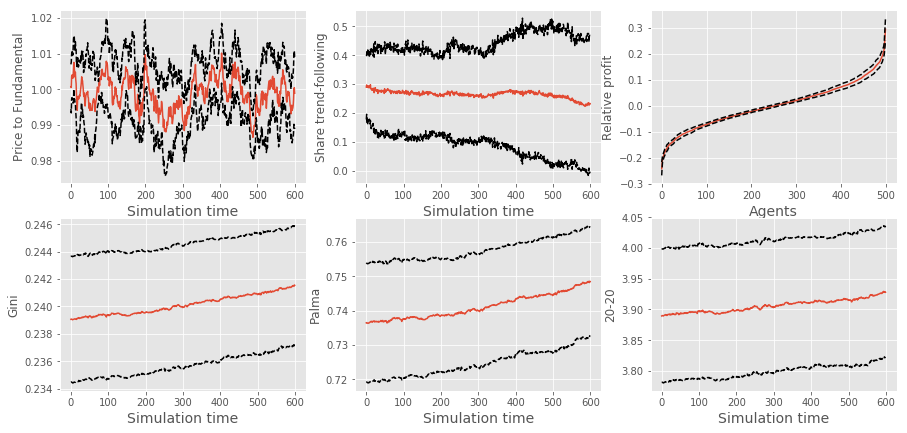

In [343]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('Price to Fundamental', fontsize='12')

ax2.plot(range(len(av_lambda[burn_in:])), av_lambda[burn_in:])
ax2.plot(range(len(av_lambda[burn_in:])), lo_lambda[burn_in:], 'k--')
ax2.plot(range(len(av_lambda[burn_in:])), up_lambda[burn_in:], 'k--')
ax2.set_ylabel('Share trend-following', fontsize='12')

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'k--')
ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'k--')
ax3.set_ylabel('Relative profit', fontsize='12')

ax4.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax4.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax5.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax5.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[:])), av_twtw_ot[:])
ax6.plot(range(len(low_gini_ot[:])), low_twtw_ot[:], 'k--')
ax6.plot(range(len(up_gini_ot[:])), up_twtw_ot[:], 'k--')
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

fig.savefig('short_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## 2.3 Steady state dynamics

In [344]:
NRUNS = 2

In [345]:
params['ticks'] = 10000#0

In [346]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1


In [347]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs, burn_in_period=200)

In [348]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

In [349]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array([c_sents]) / (np.array([c_sents]) + np.array([f_sents]))
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_interval(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_interval(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_interval(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_interval(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1920: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
c:\users\joerischasfoort\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1921: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


In [350]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [351]:
# first, order all profits, then get average profit and conf intervals 
av_ordered_profits = []
lcf_ordered_profits = []
ucf_ordered_profits = []

ordered_profits = [pd.Series(pr).sort_values() for pr in profits]
for a in range(len(ordered_profits[0])):
    a_profits = [list(p)[a] for p in ordered_profits]
    av_ordered_profits.append(np.mean(a_profits))
    low, up = confidence_interval(a_profits, np.mean(a_profits))
    lcf_ordered_profits.append(low)
    ucf_ordered_profits.append(up)

In [353]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

av_twtw_ot = []
low_twtw_ot = []
up_twtw_ot = []

for t in range(burn_in, params['ticks']):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)
    
    t_twtw = [tw[t] for tw in twtws_ot]
    av_twtw_ot.append(np.mean(t_twtw))
    low, up = confidence_interval(t_twtw, np.mean(t_twtw))
    low_twtw_ot.append(low)
    up_twtw_ot.append(up)

In [354]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_fundamentals)):
    price_range = mc_prices.iloc[row] / mc_fundamentals.iloc[row]
    lower, upper = confidence_intervalz(price_range, np.mean(price_range))
    lower_c_price.append(lower)
    upper_c_price.append(upper)

In [356]:
# what do I need, average sentiment + confidence intervals
av_fundamentalist_sentiment = []
lo_fundamentalist_sentiment = []
up_fundamentalist_sentiment = []

av_trend_sentiment = []
lo_trend_sentiment = []
up_trend_sentiment = []

av_random_sentiment = []
lo_random_sentiment = []
up_random_sentiment = []

av_lambda = []
lo_lambda = []
up_lambda = []

for t in range(len(orbs[0].sentiment_history)):
    sentiment = []
    for orderb in orbs:
        sentiment.append(market_sentiment_in_round(orderb, t))
    f_sents = [s[0] for s in sentiment]
    c_sents = [s[1] for s in sentiment]
    r_sents = [s[2] for s in sentiment]
    lmbda = np.array(c_sents) / (np.array(c_sents) + np.array(f_sents))[0]
    # calculate the average and conf intervals
    av_fundamentalist_sentiment.append(np.mean(f_sents))
    low, up = confidence_intervalz(f_sents, np.mean(f_sents))
    lo_fundamentalist_sentiment.append(low)
    up_fundamentalist_sentiment.append(up)
    
    av_trend_sentiment.append(np.mean(c_sents))
    low, up = confidence_intervalz(c_sents, np.mean(c_sents))
    lo_trend_sentiment.append(low)
    up_trend_sentiment.append(up)
    
    av_random_sentiment.append(np.mean(r_sents))
    low, up = confidence_intervalz(r_sents, np.mean(r_sents))
    lo_random_sentiment.append(low)
    up_random_sentiment.append(up)
    
    av_lambda.append(np.mean(lmbda))
    low, up = confidence_intervalz(lmbda, np.mean(lmbda))
    lo_lambda.append(low)
    up_lambda.append(up)

Text(0.5, 0, 'Agents')

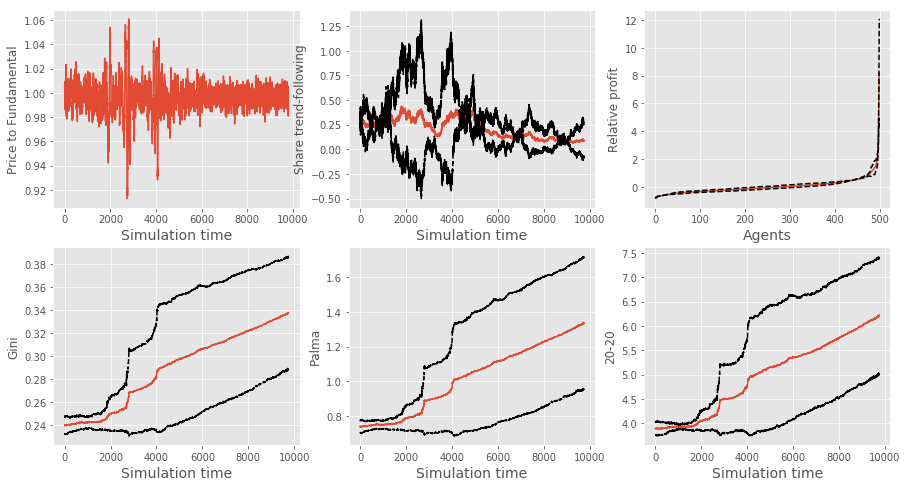

In [359]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,8))

#ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), label='Fundamental')
ax1.plot(mc_prices.index, (mc_prices.mean(axis=1) / mc_fundamentals.mean(axis=1))[:], label='Market')
#ax1.plot(mc_prices.index[:-1], lower_c_price, 'k--')
#ax1.plot(mc_prices.index[:-1], upper_c_price, 'k--')

ax1.set_ylabel('Price to Fundamental', fontsize='12')

ax2.plot(range(len(av_lambda[burn_in:])), av_lambda[burn_in:])
ax2.plot(range(len(av_lambda[burn_in:])), lo_lambda[burn_in:], 'k--')
ax2.plot(range(len(av_lambda[burn_in:])), up_lambda[burn_in:], 'k--')
ax2.set_ylabel('Share trend-following', fontsize='12')

ax3.plot(range(len(av_ordered_profits)), av_ordered_profits)
ax3.plot(range(len(av_ordered_profits)), ucf_ordered_profits, 'k--')
ax3.plot(range(len(av_ordered_profits)), lcf_ordered_profits, 'k--')
ax3.set_ylabel('Relative profit', fontsize='12')

ax4.plot(range(len(av_gini_ot[:])), av_gini_ot[:])
ax4.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax4.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax4.set_ylabel('Gini', fontsize='12')

ax5.plot(range(len(av_gini_ot[:])), av_palma_ot[:])
ax5.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax5.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax5.set_ylabel('Palma', fontsize='12')

ax6.plot(range(len(av_gini_ot[:])), av_twtw_ot[:])
ax6.plot(range(len(low_gini_ot[:])), low_twtw_ot[:], 'k--')
ax6.plot(range(len(up_gini_ot[:])), up_twtw_ot[:], 'k--')
ax6.set_ylabel('20-20', fontsize='12')

for ax in (ax1, ax2, ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    
ax3.set_xlabel('Agents', fontsize='14')

#fig.savefig('long_baseline_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)